# SoundCloud

## Introduction

Intro here.

Web scraping SoundCloud used over API since application registrations have been closed for some time now.

## Importing Libraries and Setting Up

Need to import and set up.

In [1]:
from selenium import webdriver
import time
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
import spotipy.util as util
# App credentials
from app_credentials import client_id, client_secret, redirect_uri

In [2]:
soundcloud_profile_url = 'https://soundcloud.com/kai-chang-4/'
spotify_user_id = '128095480'

## Gathering the Data

In [3]:
driver = webdriver.Chrome('C:\Chromedriver\chromedriver.exe')
driver.get('{0}likes'.format(soundcloud_profile_url))
time.sleep(1)

# Manage infinite scrolling page
last_height = driver.execute_script('return document.body.scrollHeight')
while True:
    driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
    time.sleep(2)
    new_height = driver.execute_script('return document.body.scrollHeight')
    if new_height == last_height:
        break
    else:
        last_height = new_height

soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

## Overview of the Data

In [4]:
table = []
columns = ['track_title', 'uploader', 'genre', 'plays']

songs = soup.find_all('li', attrs={'class': 'soundList__item'})

for song in songs:
    track_title = song.find('div', attrs={'class': 'soundTitle__usernameTitleContainer'}).find_all('a')[1].text.strip()
    uploader = song.find('div', attrs={'class': 'soundTitle__usernameTitleContainer'}).find_all('a')[0].text.strip()
    try:
        genre = song.find('a', attrs={'class': 'soundTitle__tag sc-tag sc-tag-small'}).text.strip()
    except AttributeError:
        genre = None
    try:
        plays = int(song.find('span', attrs={'class': 'sc-ministats sc-ministats-small sc-ministats-plays'})\
                        .get_text('|').split('|')[1].split()[0].replace(',', ''))
    except AttributeError:
        plays = None
        
    row = [track_title, uploader, genre, plays]
    table.append(row)
    
df = pd.DataFrame(table, columns=columns)
    
df

,track_title,uploader,genre,plays
0,Natural (feat Tima Dee),JAMEO,Future Bass,6894.0
1,Taska Black - In Your Eyes (ft. Ayelle),TASKA BLACK,Electronic,653430.0
2,Better Not (with Wafia),Louis The Child,Electronic,3797241.0
3,DROELOE x San Holo - Lines of the Broken (ft. CUT_),bitbird,Electronic,3055854.0
4,DROELOE - BACKBONE ft. Nevve,bitbird,Electronic,1333847.0
5,Matisyahu - Live Like A Warrior (Richello Remix),Richello,Richello,1472272.0
6,David Guetta ft. Taped Rai - Just One Last Time (Original Mix),David Guetta,Electronic House,4220564.0
7,Hardwell & Headhunterz Feat. Haris - Can Hold Us Down (OUT NOW!),HARDWELL,Progressive House,1730473.0
8,Basshunter - Now You're Gone (Noiseshock Hardstyle Rmx),Noiseshock,basshunter,456352.0
9,Noiseshock - Stratos (Original mix),Noiseshock,Noiseshock,19621.0


## Modifying the Data

In [5]:
df['track_title'] = df['track_title'].str.lower()
df['uploader'] = df['uploader'].str.lower()
df['genre'] = df['genre'].str.lower()

In [6]:
pd.options.mode.chained_assignment = None
def cleaner(df):
    artist_indicators = ' (remix|rmx|mix|flip|remake|edit|cover)'
    not_artist_indicators = '(orig(\.)?(inal)?|radio|club) (remix|rmx|mix|flip|remake|edit|cover|mashup)'
    multiple_artists_indicators = ' & | x |,| and '
    feature_indicators_a = '[ \(]f(ea)?t(uring)?[ \.]'
    feature_indicators_b = '[ \(]f(ea)?t(uring)?[ \.]| with '

    df['artist'] = None
    df['adjusted_track_title'] = None

    def clean_artist_string(x):
        return re.sub('.*[\)\(\[]', '', re.split(artist_indicators, x)[0])
    
    def clean_title_string(x):
        if '\"' in x:
            return re.split('\"', re.sub('\*[^\*]*\*', '', re.sub('[\[\(].*[\)\]]', '', x)))[1].replace('\'', '')
        else:
            return re.split('\"', re.sub('\*[^\*]*\*', '', re.sub('[\[\(].*[\)\]]', '', x)))[0].replace('\'', '')

    def drop_features(x, feature_indicators):
        if re.search(feature_indicators, x):
            return re.split(feature_indicators, x)[0]
        else:
            return x
        
    def split_multiple_artists(x):
        if re.search(multiple_artists_indicators, x):
            result = re.split(multiple_artists_indicators, x)
            return [string.strip() for string in result if string]
        else:
            return re.split(multiple_artists_indicators, x.strip())
    
    # Split track_title string into title and artist strings, features may be in either string and will be dropped later
    for row in df.itertuples():
        # If '- ' is present, then artist and title are in track title, which will be split with '- '
        if '- ' in row.track_title:
            split = row.track_title.split('- ')
            for string in split:
                # If artist_indicators such as 'remix' are present and not_artist_indicators such as 'original mix'
                # are not present, then substring contains both artist and title
                # E.g. original_artist - song_title (artist remix)
                if re.search(artist_indicators, string) and not re.search(not_artist_indicators, string):
                    df['artist'].iloc[row.Index] = string
                    df['adjusted_track_title'].iloc[row.Index] = string
            # If above indicators are not present, then artist string precedes title string
            # E.g. artist - song_title
            if not df['artist'].iloc[row.Index]:
                df['artist'].iloc[row.Index] = split[0]
                df['adjusted_track_title'].iloc[row.Index] = split[1]
        # If '- ' is not present, then artist = uploader and song = title
        else:
            df['artist'].iloc[row.Index] = row.uploader
            df['adjusted_track_title'].iloc[row.Index] = row.track_title
            
    # Clean results
    df['artist'] = df['artist'].apply(clean_artist_string)\
                               .apply(drop_features, feature_indicators = feature_indicators_b)\
                               .apply(split_multiple_artists)
    df['adjusted_track_title'] = df['adjusted_track_title'].apply(clean_title_string)\
                                                           .apply(drop_features, feature_indicators = feature_indicators_a)
    df['track_title'] = df['adjusted_track_title'].str.strip()
    
    return df[['track_title', 'artist', 'genre', 'plays']]
    
df = cleaner(df)

df

,track_title,artist,genre,plays
0,natural,[jameo],future bass,6894.0
1,in your eyes,[taska black],electronic,653430.0
2,better not,[louis the child],electronic,3797241.0
3,lines of the broken,"[droeloe, san holo]",electronic,3055854.0
4,backbone,[droeloe],electronic,1333847.0
5,live like a warrior,[richello],richello,1472272.0
6,just one last time,[david guetta],electronic house,4220564.0
7,can hold us down,"[hardwell, headhunterz]",progressive house,1730473.0
8,now youre gone,[noiseshock hardstyle],basshunter,456352.0
9,stratos,[noiseshock],noiseshock,19621.0


## Analysis of Liked Tracks

In [28]:
genre_counts = df.genre.value_counts().reset_index().rename(columns={'index': 'genre', 'genre': 'counts'})
genre_counts

,genre,counts
0,dance,50
1,progressive house,46
2,electronic,40
3,hardstyle,35
4,dance & edm,26
...,...,...
182,melodic dubstep,1
183,orchestral house,1
184,hard with style,1
185,gbe,1


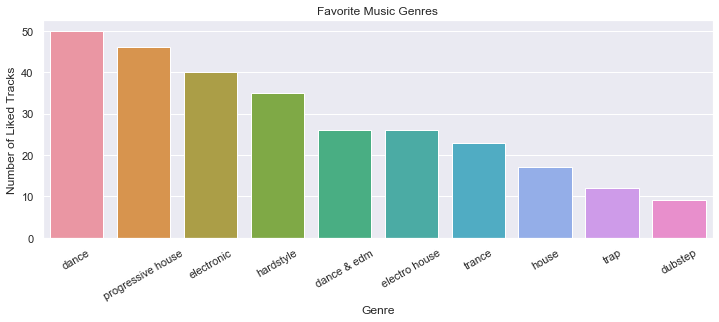

In [52]:
bar_data = genre_counts[genre_counts.counts >= 8]

sns.set(style='darkgrid', palette='husl')
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=bar_data, x='genre', y='counts')
plt.xticks(rotation=30)
ax.set_title("Favorite Music Genres")
ax.set_xlabel('Genre')
ax.set_ylabel('Number of Liked Tracks')
plt.show()

In [53]:
artist_counts = df.artist.explode().value_counts().reset_index().rename(columns={'index': 'artist', 'artist': 'counts'})
artist_counts

,artist,counts
0,vicetone,11
1,dj snake,10
2,tritonal,10
3,martin garrix,9
4,tiësto,8
...,...,...
391,frontliner,1
392,modern machines,1
393,ghastly,1
394,photographer,1


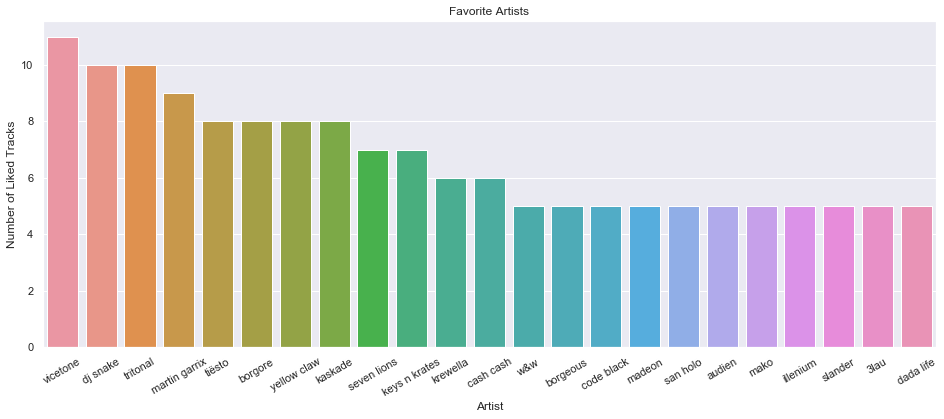

In [56]:
bar_data = artist_counts[artist_counts.counts >= 5]

fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(data=bar_data, x='artist', y='counts')
plt.xticks(rotation=30)
ax.set_title("Favorite Artists")
ax.set_xlabel('Artist')
ax.set_ylabel('Number of Liked Tracks')
plt.show()

In [93]:
df.plays.isnull().value_counts()

False    530
True       4
Name: plays, dtype: int64

In [105]:
df[df.plays.notnull()].plays.sort_values()

141          955.0
284         1543.0
478         1694.0
93          2665.0
399         3026.0
          ...     
324     70243710.0
331     72383414.0
256     73528230.0
81      74108010.0
194    172634203.0
Name: plays, Length: 530, dtype: float64

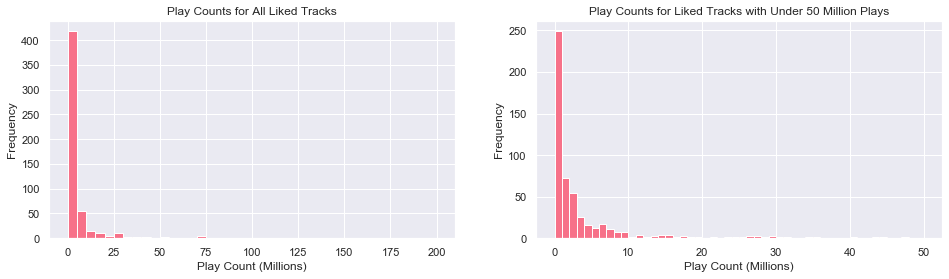

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.hist(df[df.plays.notnull()].plays, range=(0, 200000000), bins=40)
ax1.set_title("Play Counts for All Liked Tracks")
ax1.set_xlabel('Play Count (Millions)')
ax1.set_xticks(range(0, 225000000, 25000000))
ax1.set_xticklabels(['0', '25', '50', '75', '100', '125', '150', '175', '200'])
ax1.set_ylabel('Frequency')

ax2.hist(df[df.plays.notnull()].plays, range=(0, 50000000), bins=50)
ax2.set_title("Play Counts for Liked Tracks with Under 50 Million Plays")
ax2.set_xlabel('Play Count (Millions)')
ax2.set_xticks(range(0, 60000000, 10000000))
ax2.set_xticklabels(['0', '10', '20', '30', '40', '50'])
ax2.set_ylabel('Frequency')

plt.show()

In [91]:
print("The mean play count for your liked tracks is: {0}".format(df[df.plays.notnull()].plays.mean()))
print("The median play count for your liked tracks is: {0}".format(df[df.plays.notnull()].plays.median()))
print("The standard deviation for play counts for your liked tracks is: {0}".format(df[df.plays.notnull()].plays.std()))
print("The minimum value for play counts for your liked tracks is: {0}".format(df[df.plays.notnull()].plays.min()))
print("The maximum value for play counts for your liked tracks is: {0}".format(df[df.plays.notnull()].plays.max()))

The mean play count for your liked tracks is: 4986766.313207547
The median play count for your liked tracks is: 1179162.5
The standard deviation for play counts for your liked tracks is: 12542054.59346479
The minimum value for play counts for your liked tracks is: 955.0
The maximum value for play counts for your liked tracks is: 172634203.0


## Importing to Spotify Playlist

In [22]:
track_dict = {}
for idx, row in enumerate(df.itertuples()):
    track_dict[idx] = row

In [23]:
class SoundCloudToSpotify:
    scope = "playlist-modify-public"
    
    def __init__(self, username):
        self.username = username
        self.token = util.prompt_for_user_token(self.username, self.scope, client_id=client_id,
                                                client_secret=client_secret, redirect_uri=redirect_uri)
        self.sp = spotipy.Spotify(auth=self.token)
        self.sp.trace = False
        
    def create_playlist(self, playlist_name, playlist_description):
        playlist = self.sp.user_playlist_create(self.username, playlist_name, description=playlist_description)
        self.playlist_id = playlist['id']
    
    def get_spotify_track_ids(self, track_dict):
        self.track_ids = []
        specific_tracks = []
        nonspecific_tracks = []
        unable_to_find_tracks = []
                    
        for row in track_dict.values():
            artist_list = row.artist
            track = row.track_title
            idx = 0
            artist = artist_list[idx]
            result = self.sp.search(q='artist:{0} track:{1}'.format(artist, track), limit=1, type='track', market='US')
            while not result['tracks']['items'] and idx < (len(artist_list) - 1):
                idx += 1
                artist = artist_list[idx]
                result = self.sp.search(q='artist:{0} track:{1}'.format(artist, track), limit=1, type='track', market='US')
            if result['tracks']['items']:
                self.track_ids.append(result['tracks']['items'][0]['id'])
                specific_tracks.append((artist, track))
            else:
                result = self.sp.search(q='{0}'.format(track), limit=1, type='track', market='US')
                if result['tracks']['items']:
                    self.track_ids.append(result['tracks']['items'][0]['id'])
                    nonspecific_tracks.append((artist, track))
                else:
                    unable_to_find_tracks.append((artist, track))
             
        print("The following tracks were added with the specified artist and track title:")
        for (artist, track) in specific_tracks:
            print("{0}: {1}".format(artist, track))
        print()
        print("The following tracks could only be found by not specifying track information",
              "and may not have matched as intended:")
        for (artist, track) in nonspecific_tracks:
            print("{0}: {1}".format(artist, track))
        print()
        print("The following tracks could not be found:")
        for (artist, track) in unable_to_find_tracks:
            print("{0}: {1}".format(artist, track))
            
    def import_tracks_to_playlist(self, playlist_name, playlist_description, track_dict):
        self.create_playlist(playlist_name, playlist_description)
        self.get_spotify_track_ids(track_dict)
        # Spotipy allows us to add a maximum of 100 tracks at a time
        while self.track_ids:
            self.sp.user_playlist_add_tracks(self.username, self.playlist_id, self.track_ids[:100])
            self.track_ids = self.track_ids[100:]
        
user = SoundCloudToSpotify(spotify_user_id)
user.import_tracks_to_playlist("SoundCloud Tracks", "Tracks from SoundCloud Likes", track_dict)

The following tracks were added with the specified artist and track title:
jameo: natural
taska black: in your eyes
louis the child: better not
droeloe: lines of the broken
droeloe: backbone
david guetta: just one last time
hardwell: can hold us down
dj snake: loco contigo
blu j: golden dreams
san holo: i still see your face
phuture noize: circles and squares
eric prydz: opus
gryffin: all you need to know
cole plante: if i fall
nick gunner: lucid dreaming
lejend: rise above
ghastly: we might fall
said the sky: pray for me
sweater beats: symphony
droeloe: sunburn
boombox cartel: whisper
illenium: god damnit
ekali: forever
ekali: helios
adventure club: crash 2.0
don diablo: on my mind
breathe carolina: stars & moon
elephante: the in between
prxzm: silence
darren styles: us against the world
seven lions: calling you home
seven lions: horizon
seven lions: freesol
dabin: hold
ran-d: zombie
vavo: sleeping alone
avicii: the nights
super8: seconds away
darude: surrender
noah neiman: push
w&w: 

In [ ]:
# Twitch project - delete multiple drivers? Keep driver open and only quit at end?